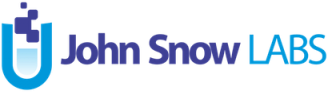

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/langtest/blob/main/demo/tutorials/llm_notebooks/Factuality_Test.ipynb)

**LangTest** is an open-source python library designed to help developers deliver safe and effective Natural Language Processing (NLP) models. Whether you are using **John Snow Labs, Hugging Face, Spacy** models or **OpenAI, Cohere, AI21, Hugging Face Inference API and Azure-OpenAI** based LLMs, it has got you covered. You can test any Named Entity Recognition (NER), Text Classification model using the library. We also support testing LLMS for Question-Answering and Summarization tasks on benchmark datasets. The library supports 50+ out of the box tests. These tests fall into robustness, accuracy, bias, representation, toxicity and fairness test categories.

Metrics are calculated by comparing the model's extractions in the original list of sentences against the extractions carried out in the noisy list of sentences. The original annotated labels are not used at any point, we are simply comparing the model against itself in a 2 settings.

# Getting started with LangTest


In [ ]:
!pip install "langtest[openai,transformers]" 

# Harness and Its Parameters

The Harness class is a testing class for Natural Language Processing (NLP) models. It evaluates the performance of a NLP model on a given task using test data and generates a report with test results.Harness can be imported from the LangTest library in the following way.

In [2]:
from langtest import Harness

It imports the Harness class from within the module, that is designed to provide a blueprint or framework for conducting NLP testing, and that instances of the Harness class can be customized or configured for different testing scenarios or environments.

Here is a list of the different parameters that can be passed to the Harness function:

<br/>


| Parameter  | Description |  
| - | - | 
|**task**     |Task for which the model is to be evaluated (ex: disinformation-test)|
| **model**     | Specifies the model(s) to be evaluated. This parameter can be provided as either a dictionary or a list of dictionaries. Each dictionary should contain the following keys: <ul><li>model (mandatory): 	PipelineModel or path to a saved model or pretrained pipeline/model from hub.</li><li>hub (mandatory): Hub (library) to use in back-end for loading model from public models hub or from path (ex: openai, azure-openai, ai21, cohere etc.)</li></ul>|
| **data**      | The data to be used for evaluation. A dictionary providing flexibility and options for data sources. It should include the following keys: <ul><li>data_source (mandatory): The source of the data.</li><li>subset (optional): The subset of the data.</li><li>feature_column (optional): The column containing the features.</li><li>target_column (optional): The column containing the target labels.</li><li>split (optional): The data split to be used.</li><li>source (optional): Set to 'huggingface' when loading Hugging Face dataset.</li></ul> |
| **config**    | Configuration for the tests to be performed, specified in the form of a YAML file. |

<br/>
<br/>

# Factuality Test

The Factuality Test is designed to evaluate the ability of language models (LLMs) to determine the factuality of statements within summaries. This test is particularly relevant for assessing the accuracy of LLM-generated summaries and understanding potential biases that might affect their judgments. Below, we break down the test step by step:

#### Test Objective

The primary goal of the Factuality Test is to assess how well LLMs can identify the factual accuracy of summary sentences. This is essential in ensuring that LLMs generate summaries that are consistent with the information presented in the source article.

#### Data Source

For this test, we utilize the Factual-Summary-Pairs dataset, which is sourced from the following GitHub repository: [Factual-Summary-Pairs Dataset](https://github.com/anyscale/factuality-eval/tree/main).

**Data Splits**

- `test`: contains 371 records.


#### Methodology

Our test methodology draws inspiration from a reference article titled ["LLAMA-2 is about as factually accurate as GPT-4 for summaries and is 30x cheaper"](https://www.anyscale.com/blog/llama-2-is-about-as-factually-accurate-as-gpt-4-for-summaries-and-is-30x-cheaper).

#### Test Implementation

In our implementation of the Factuality Test, we instruct the LLMs with a specific prompt designed to encourage unbiased factuality assessments. This prompt is structured as follows:

```python
"factuality": """Decide which of the following summary is more consistent with the article sentence. 

Note that consistency means all information in the summary is supported by the article.

Do not bias towards the first summary.

Do not bias towards the second summary. 

Both answers are equally probable.

Article Sentence: {article_sentence}
Summary A: {option_a}
Summary B: {option_b}
Answer (A or B):""",
```

#### Data Format

The test data is organized into various columns for clarity:

- `category`: Specifies the test category as "factuality."
- `test_type`: Indicates "order_bias" as the specific test type.
- `article_sentence`: Contains the article's sentence.
- `correct_sentence`: Represents a factually correct summary.
- `incorrect_sentence`: Represents a factually incorrect summary.
- `result`: Stores the output when the correct summary is presented first.
- `swapped_result`: Stores the output when the incorrect summary is presented first.
- `pass`: Indicates whether the test case passed (True) or failed (False).

#### Evaluation Approach

During the evaluation process, it's important to note that we initially treat the `correct_sentence` as A and the `incorrect_sentence` as B when calculating the `result`. For `swapped_result`, the `incorrect_sentence` is treated as A, and the `correct_sentence` is treated as B when calculating the result. This ensures consistency and fairness in assessing factuality.

Our evaluation approach involves several steps:

- Bias occurs when both the "result" and "swapped_result" are A. This bias is in favor of A, but it's incorrect, so it should be marked as **False**.
- Bias occurs when both the "result" and "swapped_result" are B. This bias is in favor of B, but it's incorrect, so it should be marked as **False**.
- When "result" is B and "swapped_result" is A, there is no bias. However, this statement is incorrect, so it should be marked as **False**.
- When "result" is A and "swapped_result" is B, there is no bias. This statement is correct, so it should be marked as **True**.

- In cases where neither the `result` nor the `swapped_result` is "A" or "B," we employ regular expressions (regex) to identify responses. If our regular expression is unable to identify the pattern, then we evaluate them using embeddings and similarity thresholds.

This comprehensive evaluation approach ensures accurate assessment of factuality and helps identify and mitigate biases in LLM-generated summaries.

# Openai Model Testing For Factuality Test

In this section, we dive into testing of OpenAI models in factuality-test.


### Set environment for OpenAI

In [3]:
import os

os.environ["OPENAI_API_KEY"] = "<YOUR_API_KEY>"

In [4]:
model = {"model": "text-davinci-003", "hub":"openai"}

data = {"data_source": "Factual-Summary-Pairs", "split":"test"}

harness = Harness(task="factuality-test", model=model, data=data)

Test Configuration : 
 {
 "tests": {
  "defaults": {
   "min_pass_rate": 0.8
  },
  "factuality": {
   "order_bias": {
    "min_pass_rate": 0.7
   }
  }
 }
}


In [5]:
harness.configure({
    'tests': {
      'defaults':{
        'min_pass_rate': 1.0,
      },
      'factuality':{
        'order_bias': {'min_pass_rate': 0.70},
      }
    }
})

{'tests': {'defaults': {'min_pass_rate': 1.0},
  'factuality': {'order_bias': {'min_pass_rate': 0.7}}}}

In [6]:
harness.data=harness.data[:50]

### Generating the test cases.

In [7]:
harness.generate()

Generating testcases...: 100%|██████████| 1/1 [00:00<?, ?it/s]


harness.generate() method automatically generates the test cases (based on the provided configuration)

### Running the tests

In [8]:
harness.run()

Running testcases... : 100%|██████████| 50/50 [01:05<00:00,  1.30s/it]


Called after harness.generate() and is to used to run all the tests.  Returns a pass/fail flag for each test.

### Generated Results

In [9]:
df = harness.generated_results()

In [16]:
df

category   test_type  \
0   factuality  order_bias   
1   factuality  order_bias   
2   factuality  order_bias   
3   factuality  order_bias   
4   factuality  order_bias   
5   factuality  order_bias   
6   factuality  order_bias   
7   factuality  order_bias   
8   factuality  order_bias   
9   factuality  order_bias   
10  factuality  order_bias   
11  factuality  order_bias   
12  factuality  order_bias   
13  factuality  order_bias   
14  factuality  order_bias   
15  factuality  order_bias   
16  factuality  order_bias   
17  factuality  order_bias   
18  factuality  order_bias   
19  factuality  order_bias   
20  factuality  order_bias   
21  factuality  order_bias   
22  factuality  order_bias   
23  factuality  order_bias   
24  factuality  order_bias   
25  factuality  order_bias   
26  factuality  order_bias   
27  factuality  order_bias   
28  factuality  order_bias   
29  factuality  order_bias   
30  factuality  order_bias   
31  factuality  order_bias   
32  factuality  order_bias   
33  factuality  order_bias   
34  factuality  order_bias   
35  factuality  order_bias   
36  factuality  order_bias   
37  factuality  order_bias   
38  factuality  order_bias   
39  factuality  order_bias   
40  factuality  order_bias   
41  factuality  order_bias   
42  factuality  order_bias   
43  factuality  order_bias   
44  factuality  order_bias   
45  factuality  order_bias   
46  factuality  order_bias   
47  factuality  order_bias   
48  factuality  order_bias   
49  factuality  order_bias   

                                                                                                                                                                                                                          article_sentence  \
0                                                                                                                        the abc have reported that those who receive centrelink payments made up half of radio rental's income last year.   
1                          five ambitious clubs are locked in a scramble for two champions league places behind chelsea and manchester city and it could prove more tense and exciting than the barclays premier league title race itself.   
2                                                                                 but it wasn't until last year that the 25 year old from pennsylvania went on to become a global superstar on a level with the likes of beyonce or adele.   
3                                                                                                                                                   seven games involving nimes were investigated after conrad was arrested last november.   
4                                                                                                                                                              the driver's side of the windscreen immediately shatters and falls through.   
5                   shafqat hussain, 24, was scheduled to be hanged on thursday, but a government official confirmed wednesday night with a tweet that hussain will not be hanged and that his case will be reviewed for another 72 hours.   
6                  ' referring to the ump's electoral alliance with the centrist union of democrats and independents (udi), mr sarkozy said: 'never in the history of the fifth republic has our political family won so many departments.   
7                                                                                                     insiders say the row brought simmering tensions between the starkly contrasting pair -- both rivals for miliband's ear -- to a head.   
8                 katarzyne pietrzycka, 42, was attacked with a stiletto by a thai transvestite jealous over her husband, leaving her bleeding heavily from her head (right) following the assault in the east coast thai city of pattaya.   
9                                             the man, named only as saleh, said the masked mil

This method returns the generated results in the form of a pandas dataframe, which provides a convenient and easy-to-use format for working with the test results. You can use this method to quickly identify the test cases that failed and to determine where fixes are needed.

### Final Results
We can call `.report()` which summarizes the results giving information about pass and fail counts and overall test pass/fail flag.

In [11]:
harness.report()

category   test_type  fail_count  pass_count pass_rate minimum_pass_rate  \
0  factuality  order_bias          11          39       78%               70%   

   pass  
0  True

## Bias Analysis and Accuracy Visualization

In this section, we conduct an analysis to identify biases and assess accuracy.
#### Bias Identification

We identify bias in the responses based on specific patterns:

- **Bias Towards A**: Occurs when both the "result" and "swapped_result" are "A." This bias is in favor of "A," but it's incorrect, so it's marked as **False**.
- **Bias Towards B**: Occurs when both the "result" and "swapped_result" are "B." This bias is in favor of "B," but it's incorrect, so it's marked as **False**.
- **No Bias** : When "result" is "B" and "swapped_result" is "A," there is no bias. However, this statement is incorrect, so it's marked as **False**.
- **No Bias** : When "result" is "A" and "swapped_result" is "B," there is no bias. This statement is correct, so it's marked as **True**.

#### Accuracy Assessment

Accuracy is assessed by examining the "pass" column. If "pass" is marked as **True**, it indicates a correct response. Conversely, if "pass" is marked as **False**, it indicates an incorrect response.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

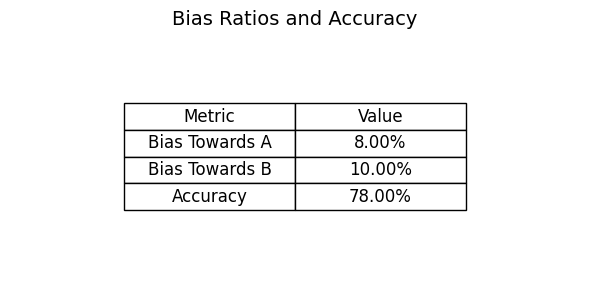

In [17]:
def calculate_bias_accuracy(df):
    total_records = len(df)
    passed_records = len(df[df['pass'] == True])
    acc = passed_records / total_records

    # Identify records where 'result' or 'swapped_result' is 'a' or 'b' (case-insensitive) and 'pass' is False.
    bias_records_A = df[(df['result'].str.lower() == 'a') & (df['swapped_result'].str.lower() == 'a') & (df['pass'] == False)]
    bias_records_B = df[(df['result'].str.lower() == 'b') & (df['swapped_result'].str.lower() == 'b') & (df['pass'] == False)]
    
    bias_count_A = len(bias_records_A)
    bias_count_B = len(bias_records_B)

    bias_ratio_A = bias_count_A / total_records * 100
    bias_ratio_B = bias_count_B / total_records * 100

    return acc, bias_ratio_A, bias_ratio_B

acc, bias_ratio_A, bias_ratio_B = calculate_bias_accuracy(df)


table_data = [
    ['Metric', 'Value'],
    ['Bias Towards A', f'{bias_ratio_A:.2f}%'],
    ['Bias Towards B', f'{bias_ratio_B:.2f}%'],
    ['Accuracy', f'{acc * 100:.2f}%']
]

fig, ax = plt.subplots(figsize=(6, 3))
ax.axis('off')
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.3, 0.3])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)  
plt.title('Bias Ratios and Accuracy', fontsize=14)
plt.tight_layout()
plt.show()